<a href="https://colab.research.google.com/github/tanushreer-7/Netflix-Data-Sentimental-Analysis-/blob/main/NETFLIX_DATA_SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**STEP-1: IMPORTING NECESSARY PACKAGES**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # For regular expressions (text cleaning)
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer # Optional: for stemming

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB # Better for text features
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download stopwords if you haven't already
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

**STEP-2: READING THE NETFLIX DATASET**

In [16]:
netflix_df = pd.read_csv('netflix_reviews.csv')
print("Dataset loaded successfully:")
print(netflix_df.head())
print(f"\nDataset shape: {netflix_df.shape}")

Dataset loaded successfully:
                               reviewId               userName  \
0  2487372e-d1ce-49b9-83a7-ed405a2911c1             QueenyTech   
1  7f278d2c-00fe-4295-9f5b-43ccdb370e79  Paresh Dalbehera (PD)   
2  42664618-3fe5-4128-af69-5012e69f4a54               Reta Ali   
3  93b3ec35-7931-4441-9920-35547c6f1584                  Jogre   
4  96cbd996-c5d5-4e23-b011-6799254ac039          Auralia Rorke   

                                             content  score  thumbsUpCount  \
0  Trash, it made me change my password because I...    1.0            0.0   
1                             I love Netflix only ❤️    5.0            0.0   
2  it's the best but pls bring back the society s...    5.0            0.0   
3  When you fold your Galaxy Fold 6, it forces Ne...    2.0            0.0   
4                                               Good    4.0            0.0   

  reviewCreatedVersion                   at           appVersion  
0    5.1.2 build 17106  2025-03-01 14:

**STEP-3: PRE-PROCESSING THE DATASET**

In [17]:
if not netflix_df.empty:
    print("Missing values before handling:")
    print(netflix_df.isnull().sum())
    netflix_df = netflix_df.drop(['reviewId', 'reviewCreatedVersion', 'appVersion', 'at'], axis=1)
    netflix_df['userName'].fillna('Unknown', inplace=True)
    netflix_df.dropna(subset=['content'], inplace=True)

    print("\nMissing values after handling:")
    print(netflix_df.isnull().sum())
    print(f"\nDataset shape after dropping rows with missing content: {netflix_df.shape}")
    print("\nCleaned DataFrame head:")
    print(netflix_df.head())

Missing values before handling:
reviewId                    0
userName                    2
content                     5
score                       1
thumbsUpCount               1
reviewCreatedVersion    11934
at                          1
appVersion              11934
dtype: int64

Missing values after handling:
userName         0
content          0
score            1
thumbsUpCount    1
dtype: int64

Dataset shape after dropping rows with missing content: (74251, 4)

Cleaned DataFrame head:
                userName                                            content  \
0             QueenyTech  Trash, it made me change my password because I...   
1  Paresh Dalbehera (PD)                             I love Netflix only ❤️   
2               Reta Ali  it's the best but pls bring back the society s...   
3                  Jogre  When you fold your Galaxy Fold 6, it forces Ne...   
4          Auralia Rorke                                               Good   

   score  thumbsUpCount  


<ipython-input-17-259ca0c9a370>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  netflix_df['userName'].fillna('Unknown', inplace=True)


**STEP-4: DEFINE SENTIMENT BASED ON SCORE**

The sentiment will be our target variable. We derive it from the 'score'.

In [18]:
if not netflix_df.empty:
    def assign_sentiment(score):
        if score >= 4:
            return 'Positive'
        elif score == 3:
            return 'Neutral'
        else:
            return 'Negative'

    netflix_df['sentiment'] = netflix_df['score'].apply(assign_sentiment)
    print("\nDataFrame with 'sentiment' column:")
    print(netflix_df[['score', 'sentiment']].head())


DataFrame with 'sentiment' column:
   score sentiment
0    1.0  Negative
1    5.0  Positive
2    5.0  Positive
3    2.0  Negative
4    4.0  Positive


**STEP-5: EXPLORATORY DATA ANALYSIS (EDA)**

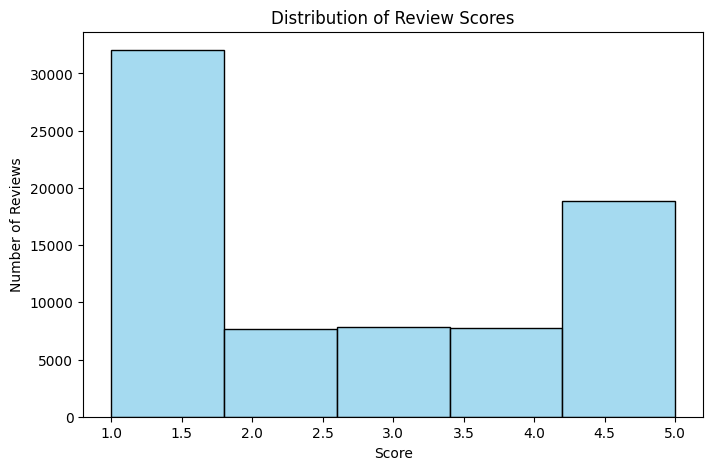

<ipython-input-19-70ff88001e0d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=netflix_df, order=['Positive', 'Neutral', 'Negative'], palette={'Positive': 'green', 'Neutral': 'blue', 'Negative': 'red'})


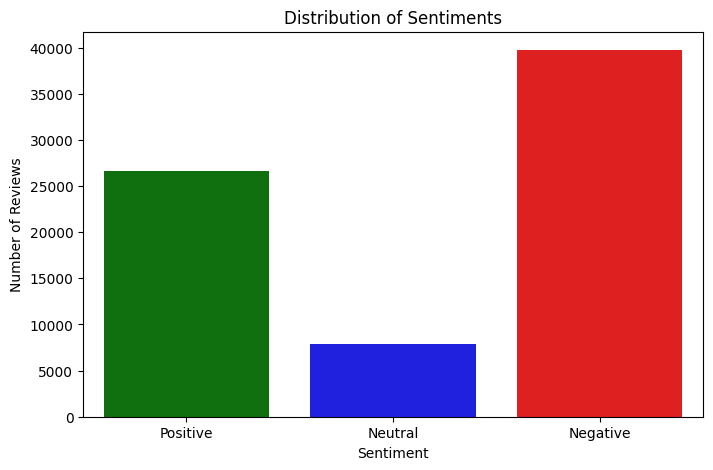


Sentiment counts:
sentiment
Negative    39755
Positive    26622
Neutral      7874
Name: count, dtype: int64


In [19]:
if not netflix_df.empty:
    plt.figure(figsize=(8, 5))
    sns.histplot(netflix_df['score'], bins=5, kde=False, color='skyblue')
    plt.title("Distribution of Review Scores")
    plt.xlabel("Score")
    plt.ylabel("Number of Reviews")
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.countplot(x='sentiment', data=netflix_df, order=['Positive', 'Neutral', 'Negative'], palette={'Positive': 'green', 'Neutral': 'blue', 'Negative': 'red'})
    plt.title("Distribution of Sentiments")
    plt.xlabel("Sentiment")
    plt.ylabel("Number of Reviews")
    plt.show()

    print("\nSentiment counts:")
    print(netflix_df['sentiment'].value_counts())

**STEP-6: TEXT PREPROCESSING FOR 'content' COLUMN**

This is a crucial step for preparing text data for machine learning.

In [20]:
if not netflix_df.empty:
    stop_words = set(stopwords.words('english'))

    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        words = text.split()
        words = [word for word in words if word not in stop_words]
        return ' '.join(words)

    print("\nStarting text preprocessing...")
    netflix_df['processed_content'] = netflix_df['content'].apply(preprocess_text)
    print("Text preprocessing complete.")
    print("\nDataFrame with 'processed_content':")
    print(netflix_df[['content', 'processed_content']].head())


Starting text preprocessing...
Text preprocessing complete.

DataFrame with 'processed_content':
                                             content  \
0  Trash, it made me change my password because I...   
1                             I love Netflix only ❤️   
2  it's the best but pls bring back the society s...   
3  When you fold your Galaxy Fold 6, it forces Ne...   
4                                               Good   

                                   processed_content  
0  trash made change password thought wrong chang...  
1                                       love netflix  
2  best pls bring back society season us interest...  
3  fold galaxy fold forces netflix use top half s...  
4                                               good  


**STEP-7: FEATURE EXTRACTION (TF-IDF) AND LABEL ENCODING**

In [21]:
if not netflix_df.empty:

    tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limit to top 5000 features for efficiency
    X_text_features = tfidf_vectorizer.fit_transform(netflix_df['processed_content'])
    print(f"\nShape of TF-IDF features: {X_text_features.shape}")

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(netflix_df['sentiment'])
    print(f"\nEncoded sentiment labels (first 5): {y_encoded[:5]}")
    print(f"Sentiment classes: {label_encoder.classes_}")

    X = X_text_features
    y = y_encoded


Shape of TF-IDF features: (74251, 5000)

Encoded sentiment labels (first 5): [0 2 2 0 2]
Sentiment classes: ['Negative' 'Neutral' 'Positive']


**STEP-8: TRAIN AND TEST THE MODEL (USING MULTINOMIAL NAIVE BAYES)**

In [22]:
if not netflix_df.empty and 'X' in locals() and 'y' in locals():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify for imbalanced classes

    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")

    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("\nModel training and prediction complete.")
else:
    print("Skipping model training as data is not prepared (e.g., file not found or empty after processing).")

Training data shape: (59400, 5000)
Testing data shape: (14851, 5000)

Model training and prediction complete.


**STEP-9: CALCULATE THE ACCURACY AND PERFORMANCE OF THE MODEL**

In [23]:
if not netflix_df.empty and 'y_test' in locals() and 'y_pred' in locals():
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.4f}") # Increased precision for accuracy
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
else:
    print("Skipping model evaluation as predictions are not available.")

Model Accuracy: 0.7619

Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.92      0.83      7951
     Neutral       0.48      0.01      0.01      1575
    Positive       0.78      0.75      0.76      5325

    accuracy                           0.76     14851
   macro avg       0.67      0.56      0.54     14851
weighted avg       0.73      0.76      0.72     14851



**STEP-10: DISPLAY THE CONFUSION MATRIX**

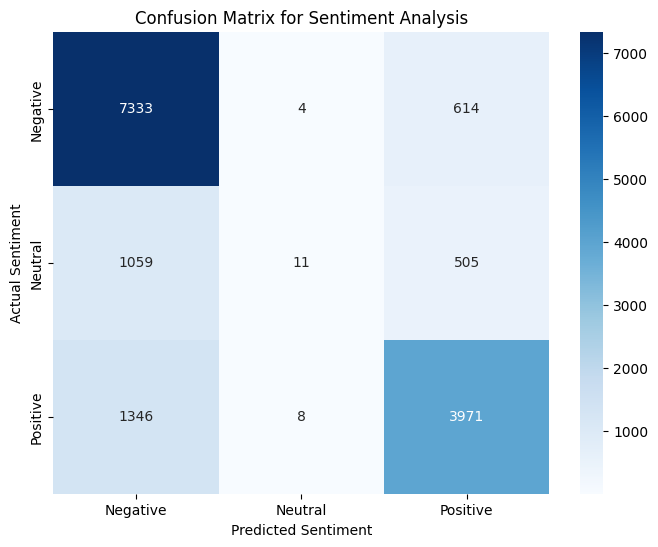

In [24]:
if not netflix_df.empty and 'y_test' in locals() and 'y_pred' in locals():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Sentiment")
    plt.ylabel("Actual Sentiment")
    plt.title("Confusion Matrix for Sentiment Analysis")
    plt.show()
else:
    print("Skipping confusion matrix display as predictions are not available.")

**STEP-11:PREDICT SENTIMENT FOR NEW REVIEWS**

In [25]:
if not netflix_df.empty and 'model' in locals() and 'tfidf_vectorizer' in locals() and 'label_encoder' in locals():
    def predict_sentiment_new_review(review_text):
        processed_review = preprocess_text(review_text)
        review_tfidf = tfidf_vectorizer.transform([processed_review])
        prediction_encoded = model.predict(review_tfidf)
        prediction_proba = model.predict_proba(review_tfidf)
        sentiment = label_encoder.inverse_transform(prediction_encoded)[0]

        formatted_probabilities = {
            label: f"{prob:.4f}"
            for label, prob in zip(label_encoder.classes_, prediction_proba[0])
        }

        print(f"Review: '{review_text}'")
        print(f"Processed: '{processed_review}'")
        print(f"Predicted Sentiment: {sentiment}")
        print(f"Probabilities: {formatted_probabilities}")
        return sentiment

    print("\n--- Testing with new reviews ---")
    predict_sentiment_new_review("This is the best movie I have ever seen! Absolutely fantastic.")
    print("\n")
    predict_sentiment_new_review("The show was okay, not great but not terrible either.")
    print("\n")
    predict_sentiment_new_review("I hated this. It was a complete waste of my time and money.")
else:
    print("Skipping new review prediction as model/vectorizer/encoder is not trained/available.")


--- Testing with new reviews ---
Review: 'This is the best movie I have ever seen! Absolutely fantastic.'
Processed: 'best movie ever seen absolutely fantastic'
Predicted Sentiment: Positive
Probabilities: {'Negative': '0.0536', 'Neutral': '0.0183', 'Positive': '0.9281'}


Review: 'The show was okay, not great but not terrible either.'
Processed: 'show okay great terrible either'
Predicted Sentiment: Negative
Probabilities: {'Negative': '0.5783', 'Neutral': '0.1606', 'Positive': '0.2611'}


Review: 'I hated this. It was a complete waste of my time and money.'
Processed: 'hated complete waste time money'
Predicted Sentiment: Negative
Probabilities: {'Negative': '0.8439', 'Neutral': '0.0503', 'Positive': '0.1058'}
